In [ ]:
# enable this to download the file if not already present

#!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

In [1]:
import numpy as np
from numba import vectorize, cuda
from struct import unpack
from ibm2ieee import ibm2float32 as i2f
import segyio
from segyio import _segyio
import cupy as cp
%config Completer.use_jedi = False

In [2]:
class ReadBinHdr(object):

    ''' Read binary trace header for a trace '''

    def __init__(self, bh):
        if len(bh) != 400:
            print("Binary header should be 400 bytes long")
        else:
            self.jobid = unpack(">i", bh[0:4])[0]
            self.line = unpack(">i", bh[4:8])[0]
            self.reel = unpack(">i", bh[8:12])[0]
            self.numtrcens = unpack(">h", bh[12:14])[0]
            self.numauxtrcs = unpack(">h", bh[14:16])[0]
            self.sampint = unpack(">h", bh[16:18])[0]
            self.sampint2 = unpack(">h", bh[18:20])[0]
            self.samppertrc = unpack(">h", bh[20:22])[0]
            self.samppertrc2 = unpack(">h", bh[22:24])[0]
            self.datasampcode = unpack(">h", bh[24:26])[0]
            self.ensfold = unpack(">h", bh[26:28])[0]
            self.sortcode = unpack(">h", bh[28:30])[0]
            self.dis_units = unpack(">h", bh[54:56])[0]
            self.segyformat = unpack(">h", bh[300:302])[0] // 256
            self.lengthflag = unpack(">h", bh[302:304])[0]
            self.numexthdrs = unpack(">h", bh[304:306])[0]
    
class ReadTrcHdr(object):
    ''' Read Trace header '''
    def __init__(self, bh):
        if len(bh) != 240:
            print("Trace Header should be 240 bytes long")
        else:
            self.inline = unpack(">i", bh[220:224])[0]
            self.xline = unpack(">i", bh[20:24])[0]
            self.sou_x = unpack(">i", bh[72:76])[0]
            self.sou_y = unpack(">i", bh[76:80])[0]

In [3]:
%%time
hdrs = []
trcs = []
with open("../Kerry3D.segy","rb") as f:
    EBCDIC = f.read(3200)
    BIN = ReadBinHdr(f.read(400))
    samples_per_trace = BIN.samppertrc
    sample_interval = BIN.sampint
    idx=1
    print("Starting loop....")
    while True:
        tmp = f.read(240)
        if not tmp:
            print("End scanning .......")
            break
        hdr = ReadTrcHdr(tmp).__dict__
        trc = f.read(samples_per_trace*4)
#         arr = ibmtoieee(np.frombuffer(trc,dtype='>u4'))
        hdrs.append(hdr)
        trcs.append(trc)
        idx+=1
data = trcs[10000] #data to perform analysis on
data[:100]

Starting loop....
End scanning .......
CPU times: user 524 ms, sys: 445 ms, total: 969 ms
Wall time: 969 ms


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbf\x94\xb9_\xc0\x1b\xe2\xc2\xc0J\\\xb0\xc0f?r\xc0x\xd6\x9d\xc0\x8bm\xc9\xc0\x94\xb9_\xc0\x94\xb9_\xc0S\xa8F@\x8bm\xc9A\x1d\xa0\xeeA%.XA\x12\x97,\xc0.y\xee\xc0\x1b\xe2\xc2@\x82"3\x00\x00\x00\x00\xc1\x10DF\xc1\x18fj'

In [4]:
# the Cuda Kernel code that runs on every unsigned int in array
ibm32cupy = cp.RawKernel(r'''
extern "C" __global__
void ibm32cupy(const unsigned int* x1, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    unsigned int x = x1[tid];
    if (x != 0){
        int sign = ((x1[tid] >> 31) & 0x01) * (-2) + 1;
        int exponent = (x1[tid] >> 24) & 0x7F;
        int tmp = 4 * (exponent - 64);
        double p;
        if (tmp < 0) {
            int po2 = 1 << (abs(tmp));
            p = (double)(1.0/po2);
        }
        else{
            p = 1 << tmp;
        }
        int mantissa = x1[tid] & 0x00ffffff;
        float frac = ((float)mantissa / 0x1000000);
        y[tid] = sign * frac * p;
    }
    else{
        y[tid] = 0.0;
    }    
}
''', 'ibm32cupy')
# vectorized version of regular python function
@vectorize(['float32(uint32)'])
def ibmpy_vec(data):
    if data == 0:
        return 0.0
    sign = data >> 31 & 0x01
    exponent = data >> 24 & 0x7f
    mantissa = (data & 0x00ffffff) / float(pow(2, 24))
    return (1 - 2 * sign) * mantissa * pow(16.0, exponent - 64)

In [5]:
#uses pypi module ibm2ieee which is cython under the hood. https://pypi.org/project/ibm2ieee/
%timeit i2f(np.frombuffer(data,dtype=">u4"))

3.71 µs ± 9.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
%timeit ibmpy_vec(np.frombuffer(data,dtype=">u4"))

3.05 µs ± 4.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
# uses cupy with a raw kernel wriiten in cuda. memory output must be preallocated
x1 = cp.array(np.frombuffer(data,dtype='>u4'),dtype=cp.uint32)
arr = cp.zeros(x1.size, dtype=cp.float32)
%timeit ibm32cupy((x1.size,), (1,), (x1, arr))

2.72 µs ± 2.95 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
times_for_i2f=[]
def ff4(trcs,n):
    for i in range(10000,10001+n):
        i2f(np.frombuffer(trcs[i],dtype=">u4"))
for n in range(0,10000,10):
    tim3 = %timeit -o -q -n 100 -r 7 ff4(trcs,n)
    times_for_i2f.append((n, tim3.average,tim3.stdev))
    if n % 500 == 0:
        print(n)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [32]:
times_for_numba=[]
def ff5(trcs,n):
    for i in range(10000,10001+n):
        ibmpy_vec(np.frombuffer(trcs[i],dtype='>u4'))
for n in range(0,10000,10):
    tim4 = %timeit -o -q -n 10 -r 5 ff5(trcs,n)
    times_for_numba.append((n, tim4.average,tim4.stdev))
    if n % 200 == 0:
        print(n)
times_for_numba

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


[(0, 2.3975179938133804e-05, 1.960053889265337e-05),
 (10, 0.00015059260003909004, 4.6087013428435346e-05),
 (20, 0.00023124596002162433, 2.5546757519298068e-05),
 (30, 0.00026245376000588294, 3.1874509493684255e-05),
 (40, 0.0003193949998967582, 1.3812063705282088e-05),
 (50, 0.00038395617993955964, 1.2794810105752676e-05),
 (60, 0.00045763144000375176, 5.688145007708424e-06),
 (70, 0.0005315988200891297, 1.6240778181309532e-06),
 (80, 0.0006288704799953848, 1.612332895197013e-05),
 (90, 0.0006893648599361768, 4.415136550913221e-06),
 (100, 0.0007834950999676949, 1.9314182170329035e-05),
 (110, 0.0008603030799713451, 1.1333765737858099e-05),
 (120, 0.0009374014999775683, 2.3387988277626752e-05),
 (130, 0.0010454028599633603, 4.057558268496425e-05),
 (140, 0.0010805885999434395, 5.870706627402188e-06),
 (150, 0.001180684359933366, 1.7138650476263125e-05),
 (160, 0.0012536566400376615, 8.960436375841361e-06),
 (170, 0.0013231985599850304, 3.7839663399913026e-06),
 (180, 0.00140910311994

In [33]:
times_for_cupy = []
def ff6(trcs,n):
    x1 = cp.array([np.frombuffer(trcs[i],dtype='>u4') for i in range(10000,10001+n)],dtype=cp.uint32)
    arr = cp.zeros(x1.size, dtype=cp.float32).reshape(x1.shape)
    ibm32cupy((x1.size,), (1,), (x1, arr))
for n in range(0,10000,10):
    tim5 = %timeit -o -q -n 10 -r 5 ff6(trcs,n)
    times_for_cupy.append((n, tim5.average,tim5.stdev))
    if n % 200 == 0:
        print(n)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


In [34]:
final = []
for x in list(zip(times_for_i2f,times_for_numba,times_for_cupy)):
    tmp = [x[0][0]]
    for y in x:
        tmp.append(y[1])
    final.append(tmp)

In [35]:
import pandas as pd

In [36]:
df = pd.DataFrame(final, columns=["N","i2f","numba","cupy"])

In [37]:
import matplotlib.pyplot as plt

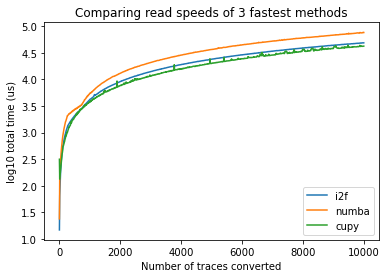

In [39]:
cols = df.columns[1:]
for col in cols:
    plt.plot(df["N"],np.log10(df[col]*1000000), label=col)
plt.legend()
plt.xlabel("Number of traces converted")
plt.ylabel("log10 total time (us)")
plt.title("Comparing read speeds of 3 fastest methods")
plt.savefig("Time read 10000 traces 3 methods.png",format='png')

In [40]:
import json

In [37]:
final

[[1,
  0.005808621669226947,
  0.0003612562857077656,
  1.2562114300505658e-05,
  5.1637714412728594e-06,
  4.835952859139069e-06,
  6.623054428408588e-05],
 [11,
  0.1085151346657464,
  0.005418070357180634,
  0.00010219121426676533,
  4.974374000864503e-05,
  6.2094192866685e-05,
  9.29621185787255e-05],
 [21,
  0.26436657666636165,
  0.01297544405700007,
  0.00019089087145403026,
  9.949521858028933e-05,
  0.00014337604713676098,
  0.00013070748429787012],
 [31,
  0.4204946353347623,
  0.020287154000003024,
  0.00027155044278645487,
  0.00014913446999604015,
  0.00022420826715201006,
  0.00017287650855515884],
 [41,
  0.5745256873318189,
  0.027761504314340917,
  0.0003751185144730178,
  0.00019830007001084073,
  0.00030167908856778273,
  0.00020120347999701542],
 [51,
  0.7370943296676463,
  0.035252848742883154,
  0.00044576941446783684,
  0.0002514250499890685,
  0.00038238195999708426,
  0.0002387253428605618],
 [61,
  0.8841755419998663,
  0.042785039242673004,
  0.000567241871

In [41]:
with open("results_10000.json","w") as jsonfile:
    jsonfile.write(json.dumps(final))